## Docling - Visual Grounding

Visual grounding is the process of locating specific objects or regions within an image based on a natural language description. \
It essentially involves a computer understanding what part of an image is being referred to by a given phrase or sentence. This \
task is often framed as "referring expression comprehension" or "phrase grounding," and it's a key component of human-like multimodal understanding.

### RAG with Docling

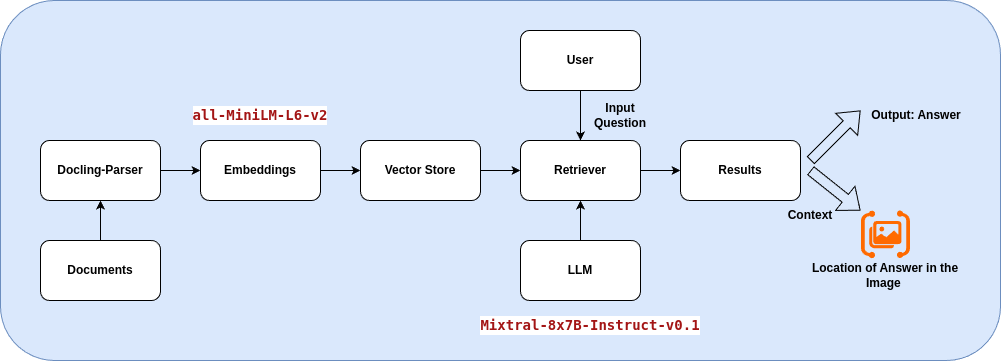

### Installing Packages

In [46]:
!pip install --progress-bar off langchain-docling langchain-core langchain-huggingface langchain_milvus langchain matplotlib python-dotenv

### Importing Packages

In [47]:
import os
from pathlib import Path
from tempfile import mkdtemp

from dotenv import load_dotenv
from langchain_core.prompts import PromptTemplate
from langchain_docling.loader import ExportType

load_dotenv()

# https://github.com/huggingface/transformers/issues/5486:
os.environ["TOKENIZERS_PARALLELISM"] = "true"

HF_TOKEN = os.getenv("HF_TOKEN")

### Document to Load

In [48]:
SOURCES = ["https://arxiv.org/pdf/2408.09869"]  # Docling Technical Report

### Embedding Model and Text-Generation Model

In [49]:
# using embedding model - all-minilm-l6-v2
EMBED_MODEL_ID = "sentence-transformers/all-MiniLM-L6-v2"

# text-generation using mixtral-8x7b instruct
GEN_MODEL_ID = "mistralai/Mixtral-8x7B-Instruct-v0.1"

### Prompt

In [50]:
# question and prompt for the model
QUESTION = "Which are the main AI models in Docling?"
PROMPT = PromptTemplate.from_template(
    "Context information is below.\n---------------------\n{context}\n---------------------\nGiven the context information and not prior knowledge, answer the query.\nQuery: {input}\nAnswer:\n",
)

### Mlivus DB path and Top-K element to retrieve

In [51]:

TOP_K = 3
MILVUS_URI = str(Path(mkdtemp()) / "docling.db")

### Initializing Document Converter with PDF Parser

In [52]:
from docling.datamodel.base_models import InputFormat
from docling.datamodel.pipeline_options import PdfPipelineOptions
from docling.document_converter import DocumentConverter, PdfFormatOption

converter = DocumentConverter(
    format_options={
        InputFormat.PDF: PdfFormatOption(
            pipeline_options=PdfPipelineOptions(
                generate_page_images=True, #to extract images
                images_scale=2.0,
            ),
        )
    }
)

### Converting the Source Document using Docling Converter and storing it as JSON

In [53]:
doc_store = {}
doc_store_root = Path(mkdtemp())
for source in SOURCES:
    dl_doc = converter.convert(source=source).document
    file_path = Path(doc_store_root / f"{dl_doc.origin.binary_hash}.json")
    dl_doc.save_as_json(file_path)
    doc_store[dl_doc.origin.binary_hash] = file_path

In [57]:
#print(open('/tmp/tmpgtman7v8/11465328351749295394.json').read())

### Chunking the document

In [58]:
from langchain_docling import DoclingLoader
from docling.chunking import HybridChunker

loader = DoclingLoader(
    file_path=SOURCES,
    converter=converter,
    export_type=ExportType.DOC_CHUNKS,
    chunker=HybridChunker(tokenizer=EMBED_MODEL_ID),
)

docs = loader.load()

Token indices sequence length is longer than the specified maximum sequence length for this model (648 > 512). Running this sequence through the model will result in indexing errors


### Chunked Document

In [59]:
for d in docs[:]:
    print("Token len: ", len(d.page_content.split(" ")))
    print(f"- {d.page_content=}")
print("...")

Token len:  52
- d.page_content='Docling Technical Report\nVersion 1.0\nChristoph Auer Maksym Lysak Ahmed Nassar Michele Dolfi Nikolaos Livathinos Panos Vagenas Cesar Berrospi Ramis Matteo Omenetti Fabian Lindlbauer Kasper Dinkla Lokesh Mishra Yusik Kim Shubham Gupta Rafael Teixeira de Lima Valery Weber Lucas Morin Ingmar Meijer Viktor Kuropiatnyk Peter W. J. Staar\nAI4K Group, IBM Research R¨ uschlikon, Switzerland'
Token len:  60
- d.page_content='Abstract\nThis technical report introduces Docling , an easy to use, self-contained, MITlicensed open-source package for PDF document conversion. It is powered by state-of-the-art specialized AI models for layout analysis (DocLayNet) and table structure recognition (TableFormer), and runs efficiently on commodity hardware in a small resource budget. The code interface allows for easy extensibility and addition of new features and models.'
Token len:  260
- d.page_content='1 Introduction\nConverting PDF documents back into a machine-processa

### Ingestion: Loading Documents to Mlivus as embedding using Embedding Model

In [60]:
import json
from pathlib import Path
from tempfile import mkdtemp

from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_milvus import Milvus

embedding = HuggingFaceEmbeddings(model_name=EMBED_MODEL_ID)


milvus_uri = str(Path(mkdtemp()) / "docling.db")  # or set as needed
vectorstore = Milvus.from_documents(
    documents=docs,
    embedding=embedding,
    collection_name="docling_demo",
    connection_args={"uri": milvus_uri},
    index_params={"index_type": "FLAT"},
    drop_old=True,
)

### RAG: Turning vector store into retriever and Loading LLM Text Generation Model with huggingface backend

In [61]:
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_huggingface import HuggingFaceEndpoint

retriever = vectorstore.as_retriever(search_kwargs={"k": TOP_K})
llm = HuggingFaceEndpoint(
    repo_id=GEN_MODEL_ID,
    huggingfacehub_api_token=HF_TOKEN,
    task='text-generation'
)


def clip_text(text, threshold=100):
    return f"{text[:threshold]}..." if len(text) > threshold else text

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


### Creating Retriever Chain on the documents

In [43]:
from docling.chunking import DocMeta
from docling.datamodel.document import DoclingDocument

question_answer_chain = create_stuff_documents_chain(llm, PROMPT) #creates chain from list of documents
rag_chain = create_retrieval_chain(retriever, question_answer_chain) #creates retrieval chain that retrieves documents
resp_dict = rag_chain.invoke({"input": QUESTION}) #

clipped_answer = clip_text(resp_dict["answer"], threshold=250)
print(f"Question:\n{resp_dict['input']}\n\nAnswer:\n{clipped_answer}")

/home/mayur/docling-venv/lib/python3.10/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please open an issue in https://github.com/huggingface/huggingface_hub.
  warnings.warn(warning_message, FutureWarning)


Question:
Which are the main AI models in Docling?

Answer:
The main AI models in Docling are a layout analysis model and TableFormer. The layout analysis model is an accurate object-detector for page elements, while TableFormer is a state-of-the-art table structure recognition model. Both models are availabl...


In [44]:
resp_dict

{'input': 'Which are the main AI models in Docling?',
 'context': [Document(metadata={'dl_meta': {'schema_name': 'docling_core.transforms.chunker.DocMeta', 'version': '1.0.0', 'doc_items': [{'self_ref': '#/texts/50', 'parent': {'$ref': '#/body'}, 'children': [], 'content_layer': 'body', 'label': 'text', 'prov': [{'page_no': 3, 'bbox': {'l': 108.0, 't': 404.873, 'r': 504.003, 'b': 330.866, 'coord_origin': 'BOTTOMLEFT'}, 'charspan': [0, 608]}]}], 'headings': ['3.2 AI models'], 'origin': {'mimetype': 'application/pdf', 'binary_hash': 11465328351749295394, 'filename': '2408.09869v5.pdf'}}, 'pk': 457769926439993350, 'source': 'https://arxiv.org/pdf/2408.09869'}, page_content='3.2 AI models\nAs part of Docling, we initially release two highly capable AI models to the open-source community, which have been developed and published recently by our team. The first model is a layout analysis model, an accurate object-detector for page elements [13]. The second model is TableFormer [12, 9], a stat

### Visual Grounding

Source 1:
  text: "3.2 AI models\nAs part of Docling, we initially release two highly capable AI models to the open-source community, which have been developed and published recently by our team. The first model is a layout analysis model, an accurate object-detector for page elements [13]. The second model is TableFormer [12, 9], a state-of-the-art table structure re..."
  page: 3


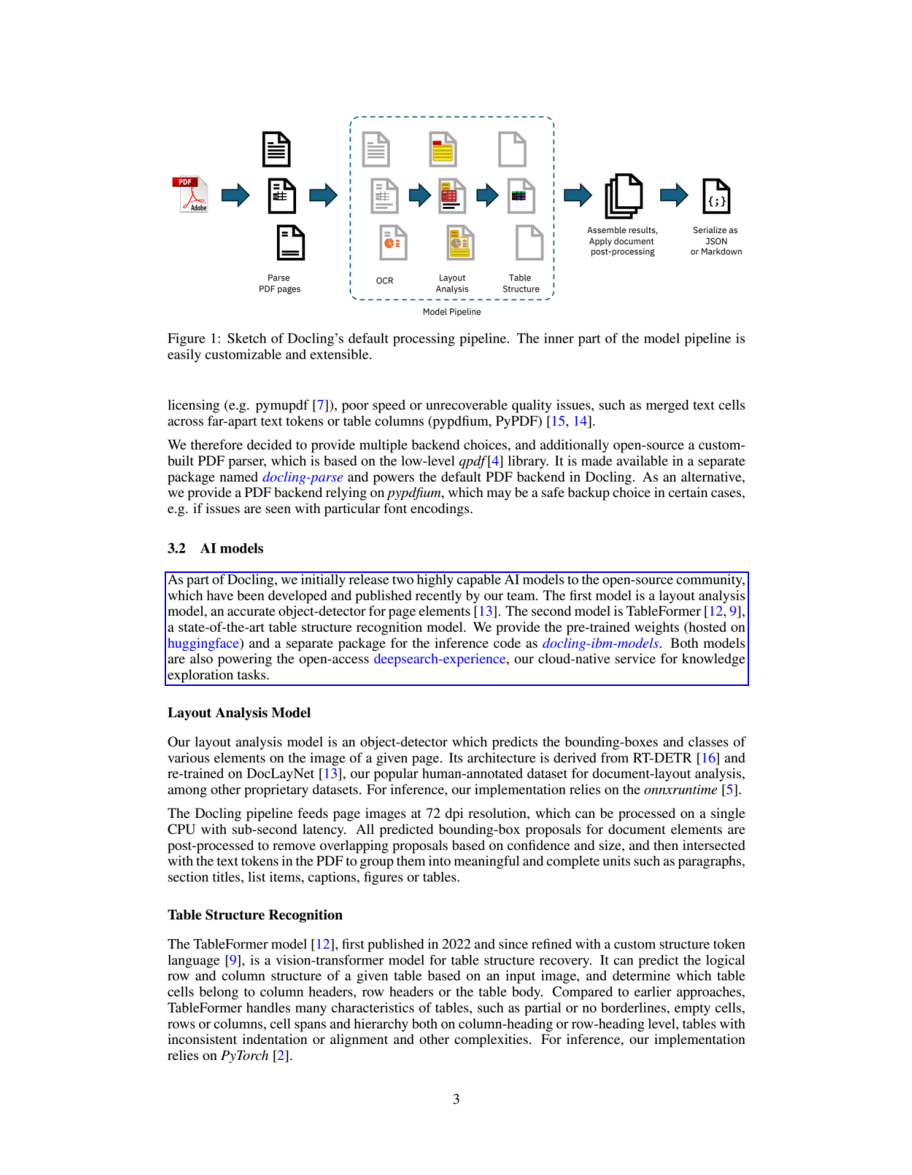

Source 2:
  text: "3 Processing pipeline\nDocling implements a linear pipeline of operations, which execute sequentially on each given document (see Fig. 1). Each document is first parsed by a PDF backend, which retrieves the programmatic text tokens, consisting of string content and its coordinates on the page, and also renders a bitmap image of each page to support ..."
  page: 2


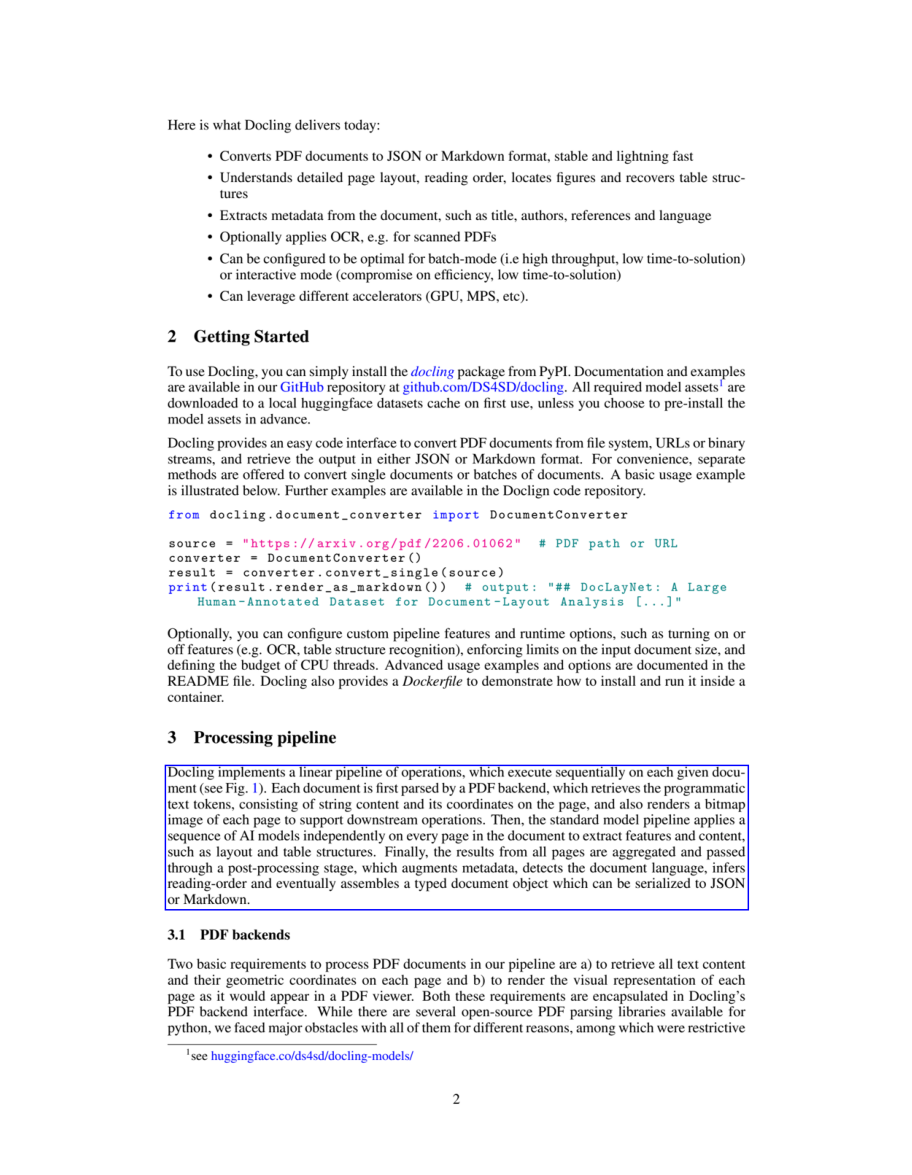

Source 3:
  text: "6 Future work and contributions\nDocling is designed to allow easy extension of the model library and pipelines. In the future, we plan to extend Docling with several more models, such as a figure-classifier model, an equationrecognition model, a code-recognition model and more. This will help improve the quality of conversion for specific types of ..."
  page: 5


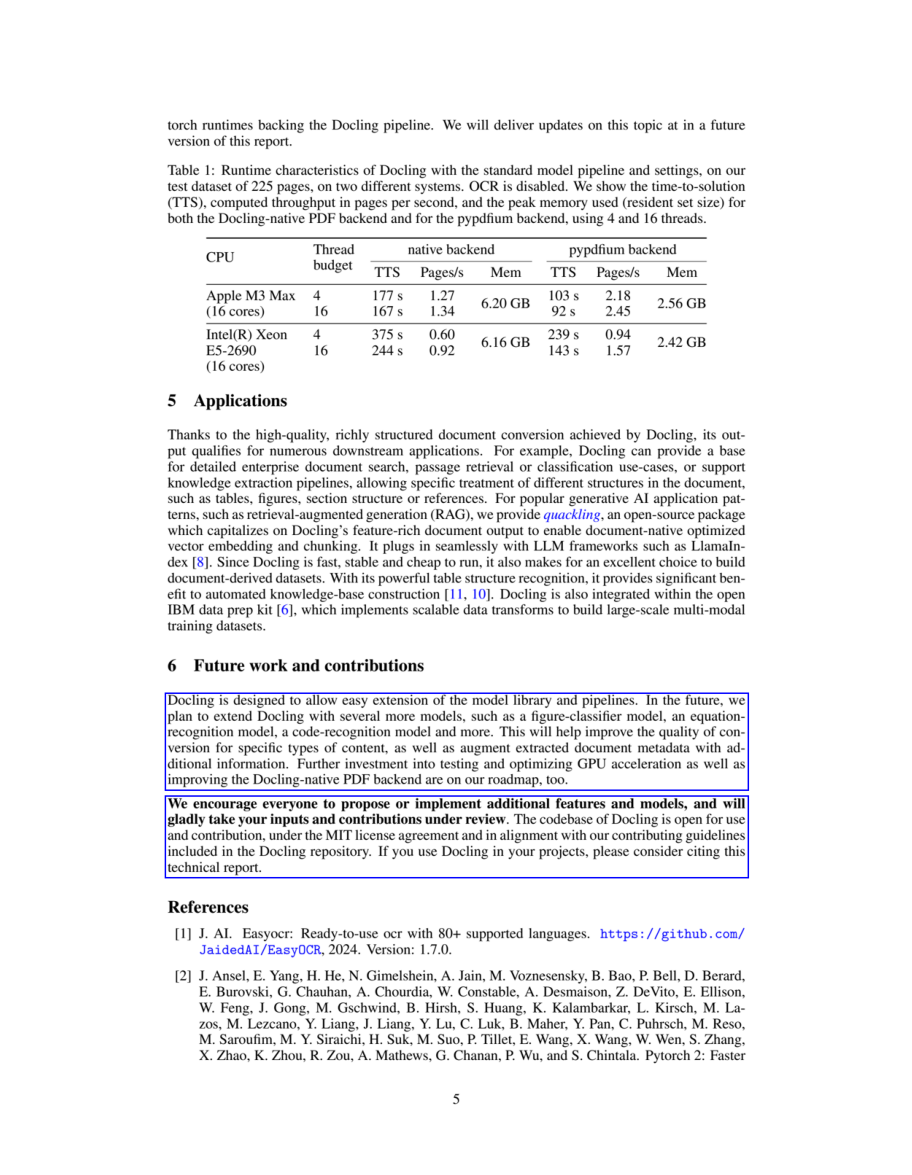

In [45]:
import matplotlib.pyplot as plt
from PIL import ImageDraw

for i, doc in enumerate(resp_dict["context"][:]):
    image_by_page = {}
    print(f"Source {i + 1}:")
    print(f"  text: {json.dumps(clip_text(doc.page_content, threshold=350))}")
    meta = DocMeta.model_validate(doc.metadata["dl_meta"])

    # loading the full DoclingDocument from the document store:
    dl_doc = DoclingDocument.load_from_json(doc_store.get(meta.origin.binary_hash))

    for doc_item in meta.doc_items:
        if doc_item.prov:
            prov = doc_item.prov[0]  # here we only consider the first provenence item
            page_no = prov.page_no
            if img := image_by_page.get(page_no):
                pass
            else:
                page = dl_doc.pages[prov.page_no]
                print(f"  page: {prov.page_no}")
                img = page.image.pil_image
                image_by_page[page_no] = img
            bbox = prov.bbox.to_top_left_origin(page_height=page.size.height)
            bbox = bbox.normalized(page.size)
            thickness = 2
            padding = thickness + 2
            bbox.l = round(bbox.l * img.width - padding)
            bbox.r = round(bbox.r * img.width + padding)
            bbox.t = round(bbox.t * img.height - padding)
            bbox.b = round(bbox.b * img.height + padding)
            draw = ImageDraw.Draw(img)
            draw.rectangle(
                xy=bbox.as_tuple(),
                outline="blue",
                width=thickness,
            )
    for p in image_by_page:
        img = image_by_page[p]
        plt.figure(figsize=[15, 15])
        plt.imshow(img)
        plt.axis("off")
        plt.show()